In [1]:
import torch
import torch.nn.functional as F
from torch_geometric.datasets import Flickr, Coauthor, CoraFull, Planetoid
from torch_geometric.nn import GCNConv
from torch_geometric.loader import NeighborLoader
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from tqdm import tqdm

/home/vamsi/miniconda3/envs/isl/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
np.random.seed(69420)
torch.manual_seed(69420)

In [33]:
# Load the Flickr dataset
dataset = Planetoid(root='data/Planetoid', name='Cora')
data = dataset[0]  # The dataset contains a single graph

In [34]:
data

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])

In [35]:
def edge_index_to_adj(edge_index, num_nodes):
    values = torch.ones(edge_index.shape[1])
    adj_matrix = torch.sparse_coo_tensor(edge_index, values, (num_nodes, num_nodes))
    return adj_matrix.to_dense()
B = edge_index_to_adj(data.edge_index, len(data.x))

In [36]:
torch.sum(B)/2 # Number of edges in adjacency matrix (incorrect becoz not counting self edges on diagonal)

tensor(5278.)

In [87]:
M = torch.tensor(data.x)
M.to(torch.device('cuda'))
A = (M@M.T)

/tmp/ipykernel_30102/3050583016.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  M = torch.tensor(data.x)


### Here we are only considering those dot products in A which are not there as edges in B (NOTE this if you are accounting edge weights from dot product!) Also remove all self dot products (NO SELF EDGES!!)

In [104]:
#M = (B==0).long() * A * (torch.eye(len(A)) == 0).long()
M = A * (torch.eye(len(A)) == 0).long()
M

tensor([[0., 1., 1.,  ..., 1., 2., 2.],
        [1., 0., 3.,  ..., 2., 1., 1.],
        [1., 3., 0.,  ..., 2., 1., 1.],
        ...,
        [1., 2., 2.,  ..., 0., 0., 1.],
        [2., 1., 1.,  ..., 0., 0., 2.],
        [2., 1., 1.,  ..., 1., 2., 0.]])

In [101]:
torch.sum((M<5).long()*M)

tensor(7249506.)

(array([1.73232e+05, 4.83240e+04, 1.24680e+04, 0.00000e+00, 3.26400e+03,
        9.44000e+02, 0.00000e+00, 2.66000e+02, 1.36000e+02, 0.00000e+00,
        5.20000e+01, 3.80000e+01, 0.00000e+00, 1.60000e+01, 4.00000e+01,
        0.00000e+00, 2.00000e+01, 1.60000e+01, 0.00000e+00, 1.40000e+01,
        2.80000e+01, 0.00000e+00, 1.80000e+01, 1.80000e+01, 0.00000e+00,
        1.80000e+01, 4.00000e+00, 0.00000e+00, 2.00000e+00, 1.20000e+01,
        8.00000e+00]),
 array([ 4.        ,  4.67741919,  5.35483885,  6.03225803,  6.70967722,
         7.38709688,  8.06451607,  8.74193573,  9.41935444, 10.0967741 ,
        10.77419376, 11.45161247, 12.12903214, 12.8064518 , 13.48387051,
        14.16129017, 14.83870983, 15.51612949, 16.1935482 , 16.87096786,
        17.54838753, 18.22580719, 18.90322495, 19.58064461, 20.25806427,
        20.93548393, 21.61290359, 22.29032326, 22.96774101, 23.64516068,
        24.32258034, 25.        ]),
 <BarContainer object of 31 artists>)

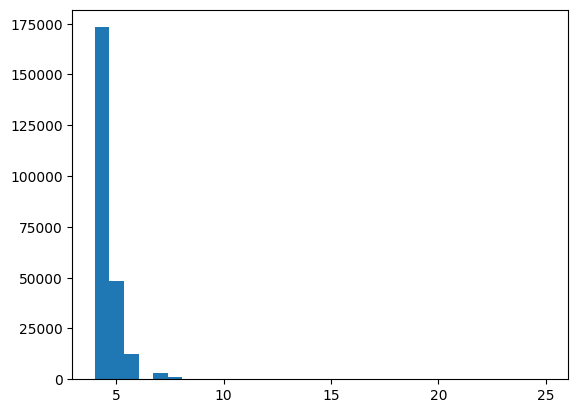

In [ ]:
alpha = 5
beta = 7
M = (M>alpha).long()*M
plt.hist(M.reshape(-1)[M.reshape(-1)!=0],bins=31)

In [105]:
M = ((B*(M>5).long()*M)!=0).long()
torch.sum(M)

tensor(1332)

In [106]:
# Boolianize
M = (M!=0).long()
torch.sum(M), 4122/(len(M)**2)

(tensor(1332), 0.0005620962234552036)

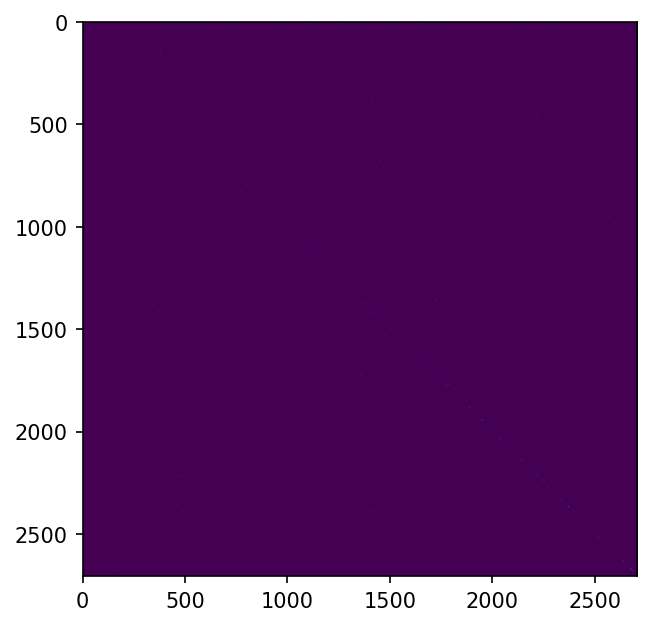

In [107]:

plt.figure(dpi=150) # Set DPI to 150 or more for higher resolution
plt.imshow(M)

tensor(10556)

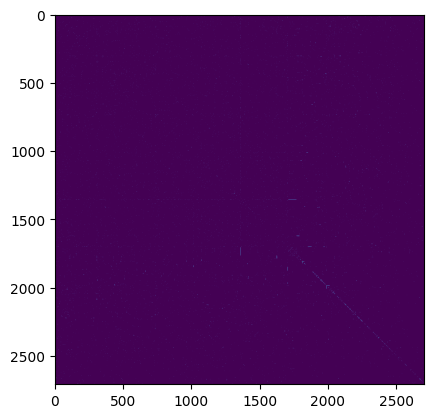

In [108]:
edges = data.edge_index

# Determine the number of unique nodes
num_nodes = torch.max(edges) + 1  # Maximum node ID + 1 (assuming 0-based indexing)

# Initialize an adjacency matrix (symmetric, binary)
adj_matrix = torch.zeros((num_nodes, num_nodes), dtype=torch.int)

# Use advanced indexing to update the adjacency matrix
i, j = edges
adj_matrix[i, j] = 1
adj_matrix[j, i] = 1  # For undirected graph

# plt.figure(dpi=560)
plt.imshow(adj_matrix)
torch.sum(adj_matrix)

In [109]:
print(f'ADJ MATRIX: {torch.sum(adj_matrix)}\nATTRIBUTE SIM MATRIX: {torch.sum(M)}\nSUM: {torch.sum(M+adj_matrix)}\nOverlapping Edges: {(torch.sum(adj_matrix)+torch.sum(M))-torch.sum(M+adj_matrix)}')

ADJ MATRIX: 10556
ATTRIBUTE SIM MATRIX: 1332
SUM: 11888
Overlapping Edges: 0


In [110]:
final_matrix = adj_matrix+M
i, j = torch.where(final_matrix == 1)
edges = torch.stack((i, j), dim=0)
print(edges, edges.shape)

tensor([[   0,    0,    0,  ..., 2707, 2707, 2707],
        [ 633, 1862, 2582,  ...,  598, 1473, 2706]]) torch.Size([2, 9224])


In [111]:
save_edges = lambda args: pd.DataFrame(args[0].T).to_csv(args[1],index=None, header=None, sep=' ', mode='a')
def get_embeddings(
    edges, 
    edges_name="edgelist.txt", 
    k=128,  # Embedding dimension
    a=0.01,  # damping parameter
    partition=1,
    output=False
):
    '''
    "partition": the partition algorithm to use, default is 1.
    0: random bisection
    1: Louvain partition
    2: Louvain first-level partition
    3: Label Propagation partition
    '''
    save_edges((edges, edges_name))
    
    if not os.path.exists('./hierarchy.txt'):
        os.mknod('./hierarchy.txt')
    if not os.path.exists('./vectors.txt'):
        os.mknod('./vectors.txt')
    
    endstr = '> /dev/null 2>&1'
    if(output):
        endstr = ''
    os.system(f'./LouvainNE/recpart ./{edges_name} ./hierarchy.txt {partition} {endstr}')
    os.system(f'./LouvainNE/hi2vec {k} {a} ./hierarchy.txt ./vectors.txt {endstr}')
    
    # Path to your text file
    file_path = 'vectors.txt'


    # Read the entire file at once using NumPy's loadtxt
    data_ = np.loadtxt(file_path)

    # Convert the data into a PyTorch tensor
    data_tensor = torch.from_numpy(data_)

    # The first column contains node IDs
    node_ids = data_tensor[:, 0].to(torch.int)

    # The remaining columns contain embeddings
    embeddings = data_tensor[:, 1:]
    
    return node_ids, embeddings


In [112]:
node_ids, embeddings = get_embeddings(edges)


/tmp/ipykernel_30102/4201394003.py:6: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[0].legend()
/tmp/ipykernel_30102/4201394003.py:11: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[1].legend()
/tmp/ipykernel_30102/4201394003.py:16: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[2].legend()


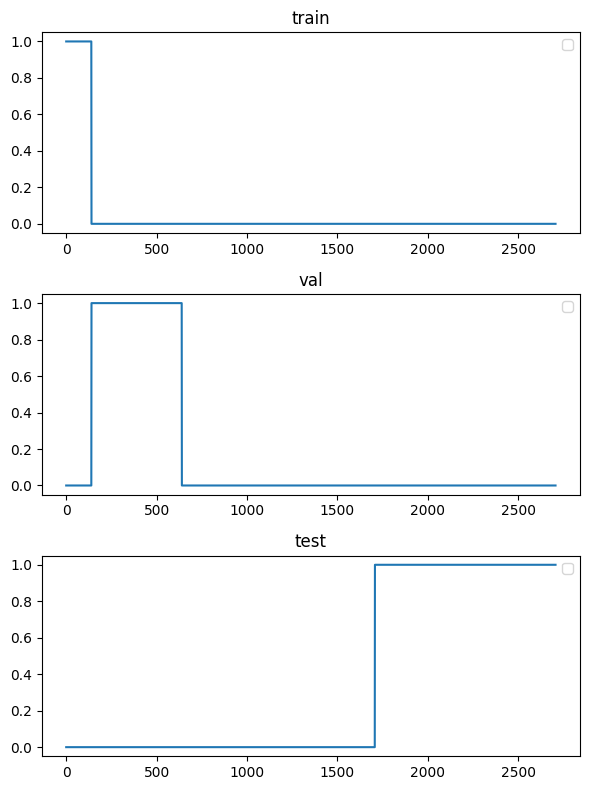

% data used: tensor(0.6056)


In [113]:
fig, axs = plt.subplots(3, 1, figsize=(6, 8))

# Plot the first graph
axs[0].plot(data.train_mask.long())
axs[0].set_title('train')
axs[0].legend()

# Plot the second graph
axs[1].plot(data.val_mask.long())
axs[1].set_title('val')
axs[1].legend()

# Plot the third graph
axs[2].plot(data.test_mask.long())
axs[2].set_title('test')
axs[2].legend()

# Adjust layout for better spacing
plt.tight_layout()

# Show the plots
plt.show()
#plt.plot(data.test_mask.long()+data.train_mask.long()+data.val_mask.long())
print('% data used:', torch.sum(data.test_mask.long()+data.train_mask.long()+data.val_mask.long())/len(data.train_mask.long()))

# Logistic Regression based Multilabel classification

In [114]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.preprocessing import MultiLabelBinarizer
import torch
import numpy as np

def evaluate_node_classification(node_ids, embeddings, data):
    """
    Evaluate node classification using the provided embeddings
    
    Args:
        node_ids: Array of node IDs
        embeddings: Node embeddings corresponding to node_ids
        data: PyTorch Geometric data object containing labels and masks
    """
    # Create a mapping from node_id to its position in the embeddings array
    node_to_idx = {node_id.item(): idx for idx, node_id in enumerate(node_ids)}
    
    # Get the embeddings in the same order as the labels
    ordered_embeddings = np.zeros((len(data.y), embeddings.shape[1]))
    for i in range(len(data.y)):
        ordered_embeddings[i] = embeddings[node_to_idx[i]]
    
    # Convert masks to numpy for easier handling
    train_mask = data.train_mask.numpy()
    test_mask = data.test_mask.numpy()
    
    # Get train and test sets
    X_train = ordered_embeddings[train_mask]
    X_test = ordered_embeddings[test_mask]
    y_train = data.y[train_mask].numpy()
    y_test = data.y[test_mask].numpy()
    
    # Train logistic regression classifier
    clf = LogisticRegression(max_iter=1000, multi_class='multinomial')
    clf.fit(X_train, y_train)
    
    # Make predictions
    y_pred = clf.predict(X_test)
    
    # Calculate metrics
    micro_f1 = f1_score(y_test, y_pred, average='micro')
    macro_f1 = f1_score(y_test, y_pred, average='macro')
    
    return {
        'micro_f1': micro_f1,
        'macro_f1': macro_f1
    }

# Example usage
# Assuming your data is already loaded
def print_results_llml(node_ids, embeddings, data, print=True):
    results = evaluate_node_classification(node_ids, embeddings, data)
    if(print):
        print("\nNode Classification Results:")
        print(f"Micro-F1: {results['micro_f1']:.4f}")
        print(f"Macro-F1: {results['macro_f1']:.4f}")
    
    return results['micro_f1'], results['macro_f1']

# Logistic Regression & Classifier Chain based Multilabel classification

In [115]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.multioutput import ClassifierChain
from sklearn.preprocessing import MultiLabelBinarizer
import torch
import numpy as np

def evaluate_node_classification(node_ids, embeddings, data):
    """
    Evaluate node classification using classifier chains
    
    Args:
        node_ids: Array of node IDs
        embeddings: Node embeddings corresponding to node_ids
        data: PyTorch Geometric data object containing labels and masks
    """
    # Create a mapping from node_id to its position in the embeddings array
    node_to_idx = {node_id.item(): idx for idx, node_id in enumerate(node_ids)}
    
    # Get the embeddings in the same order as the labels
    ordered_embeddings = np.zeros((len(data.y), embeddings.shape[1]))
    for i in range(len(data.y)):
        ordered_embeddings[i] = embeddings[node_to_idx[i]]
    
    # Convert masks to numpy for easier handling
    train_mask = data.train_mask.numpy()
    test_mask = data.test_mask.numpy()
    
    # Get train and test sets
    X_train = ordered_embeddings[train_mask]
    X_test = ordered_embeddings[test_mask]
    
    # Convert labels to one-hot encoding for multi-label classification
    num_classes = len(torch.unique(data.y))
    y_one_hot = np.zeros((len(data.y), num_classes))
    for i in range(len(data.y)):
        y_one_hot[i, data.y[i]] = 1
    
    y_train = y_one_hot[train_mask]
    y_test = y_one_hot[test_mask]
    
    # Initialize and train classifier chain
    base_classifier = LogisticRegression(max_iter=1000)
    chains = ClassifierChain(base_classifier, order='random', random_state=42)
    chains.fit(X_train, y_train)
    
    # Make predictions
    y_pred = chains.predict(X_test)
    
    # Calculate metrics
    micro_f1 = f1_score(y_test, y_pred, average='micro')
    macro_f1 = f1_score(y_test, y_pred, average='macro')
    
    return {
        'micro_f1': micro_f1,
        'macro_f1': macro_f1
    }

def print_results_clschain(node_ids, embeddings, data, print=True):
    """Run multiple iterations and print averaged results"""
    num_iterations = 100  # As mentioned in the paper
    micro_f1_scores = []
    macro_f1_scores = []
    
    for i in range(num_iterations):
        results = evaluate_node_classification(node_ids, embeddings, data)
        micro_f1_scores.append(results['micro_f1'])
        macro_f1_scores.append(results['macro_f1'])
    
    avg_micro_f1 = np.mean(micro_f1_scores)
    avg_macro_f1 = np.mean(macro_f1_scores)
    std_micro_f1 = np.std(micro_f1_scores)
    std_macro_f1 = np.std(macro_f1_scores)
    
    if(print):
        print("\nNode Classification Results (averaged over 100 iterations):")
        print(f"Micro-F1: {avg_micro_f1:.4f} ± {std_micro_f1:.4f}")
        print(f"Macro-F1: {avg_macro_f1:.4f} ± {std_macro_f1:.4f}")
    
    return avg_micro_f1,std_micro_f1,avg_macro_f1,std_macro_f1

In [118]:
final_matrix = adj_matrix
i, j = torch.where(final_matrix == 1)
edges = torch.stack((i, j), dim=0)

print('Only Initial Edges:')
a = []
b = []
for i in tqdm(range(256)):
    aa_node_ids, aa_embeddings = get_embeddings(edges, "attrubute_added_edgelist.txt", k=128, partition=1)
    c,d = print_results_llml(aa_node_ids, aa_embeddings, data, print=False)
    a.append(c)
    b.append(d)

print(f"Micro-F1: {np.mean(a):.4f} ± {np.std(a):.4f}")
print(f"Macro-F1: {np.mean(b):.4f} ± {np.std(b):.4f}")

final_matrix = M
i, j = torch.where(final_matrix == 1)
edges = torch.stack((i, j), dim=0)

print('Only Attribute Edges:')
a = []
b = []
for i in tqdm(range(256)):
    aa_node_ids, aa_embeddings = get_embeddings(edges, "attrubute_added_edgelist.txt", k=128, partition=1)
    c,d = print_results_llml(aa_node_ids, aa_embeddings, data, print=False) 
    a.append(c)
    b.append(d)

print(f"Micro-F1: {np.mean(a):.4f} ± {np.std(a):.4f}")
print(f"Macro-F1: {np.mean(b):.4f} ± {np.std(b):.4f}")

final_matrix = adj_matrix+M
i, j = torch.where(final_matrix == 1)
edges = torch.stack((i, j), dim=0)

print('Combined Edges:')
a = []
b = []
for i in tqdm(range(256)):
    aa_node_ids, aa_embeddings = get_embeddings(edges, "attrubute_added_edgelist.txt", k=128, partition=1)
    c,d = print_results_llml(aa_node_ids, aa_embeddings, data, print=False)
    a.append(c)
    b.append(d)

print(f"Micro-F1: {np.mean(a):.4f} ± {np.std(a):.4f}")
print(f"Macro-F1: {np.mean(b):.4f} ± {np.std(b):.4f}")

Only Initial Edges:


100%|██████████| 256/256 [21:15<00:00,  4.98s/it]


Micro-F1: 0.7251 ± 0.0105
Macro-F1: 0.7142 ± 0.0082
Only Attribute Edges:


100%|██████████| 256/256 [22:28<00:00,  5.27s/it]


Micro-F1: 0.7130 ± 0.0133
Macro-F1: 0.7043 ± 0.0123
Combined Edges:


100%|██████████| 256/256 [23:55<00:00,  5.61s/it]

Micro-F1: 0.6991 ± 0.0156
Macro-F1: 0.6892 ± 0.0131


# GCN Stuff

In [ ]:

# Define a simple Graph Convolutional Network (GCN)
class GCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

# Initialize the model, optimizer, and loss function
model = GCN(in_channels=data.num_features, hidden_channels=64, out_channels=dataset.num_classes)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
loss_fn = torch.nn.NLLLoss()

# Split the dataset into train, validation, and test sets
train_mask, val_mask, test_mask = data.train_mask, data.val_mask, data.test_mask

# Training loop
def train():
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = loss_fn(out[train_mask], data.y[train_mask])
    loss.backward()
    optimizer.step()
    return loss.item()

# Evaluation function
def evaluate(mask):
    model.eval()
    with torch.no_grad():
        out = model(data.x, data.edge_index)
        pred = out.argmax(dim=1)
        correct = (pred[mask] == data.y[mask]).sum()
        acc = correct / mask.sum()
    return acc.item()

# Train the model
for epoch in range(200):
    loss = train()
    if epoch % 20 == 0:
        val_acc = evaluate(val_mask)
        print(f'Epoch {epoch}, Loss: {loss:.4f}, Val Accuracy: {val_acc:.4f}')

# Test the model
test_acc = evaluate(test_mask)
print(f'Test Accuracy: {test_acc:.4f}')


In [109]:

os.system('ls')

LouvainNE
data
edgelist.txt
hierarchy.txt
node_classification copy.ipynb
node_classification.ipynb
vectors.txt


0

In [89]:
!git clone https://github.com/maxdan94/LouvainNE.git

Cloning into 'LouvainNE'...
remote: Enumerating objects: 217, done.
remote: Counting objects: 100% (9/9), done.
remote: Compressing objects: 100% (7/7), done.
remote: Total 217 (delta 2), reused 9 (delta 2), pack-reused 208 (from 1)
Receiving objects: 100% (217/217), 65.80 KiB | 863.00 KiB/s, done.
Resolving deltas: 100% (125/125), done.
